# CNN-TDA Net Tutorial: MNIST Classification

## 1. Setting

In [1]:
import sys
sys.path.append('../')

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

- Let's set a random seed for reproducibility. This step requires TensorFlow > 2.8.0 for `tf.config.experimental.enable_op_determinism()`

In [2]:
from cnntdanet.utils import seed_all

seed = 0
seed_all(seed)

## 2. Loading HMNIST dataset
- We will use the first 6,000 data for a quick implementation.

In [3]:
df = pd.read_csv('../datasets/skin-cancer/hmnist_28_28_L.csv')

X = df.drop('label', axis=1).values.reshape((-1, 28, 28, 1))
y = df['label'].values

X = X.astype(np.float32)
X /= 255.0

y = y.astype(np.int64)

- `cnntdanet` has many utility functions for visualization. Let's visualize 16 data that are chosen at random.

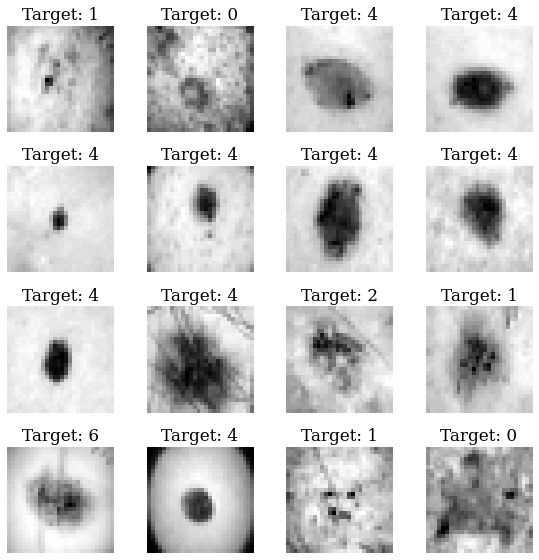

In [4]:
from cnntdanet.utils.plotting import visualize_image_samples

# The number of random samples
N = 16

# Choose random indices
sample_indices = np.random.choice(a=range(len(X)), size=16)

# Take samples
samples = X[sample_indices]
target = y[sample_indices]

visualize_image_samples(samples, y[sample_indices], scale=2)

## 3. Create topological features
- `cnntdanet` create a topological feature using `giotto-tda`.
- We  have predefined `gtda.pipeline.Pipeline`s for persistence image, persistence landscape, and betti-curve.
- You can make your own tda pipeline by using `gtda.pipeline.Pipeline`.

In [5]:
from cnntdanet.tda import get_tda_pipeline

# The method name should be one of ['persistence-image', 'persistence-landscape', 'betti-curve']
method = 'betti-curve'

# For each method, you should define some required arguments.
n_bins = 100

# Build a gtda.pipeline.Pipeline
pipeline = get_tda_pipeline(method=method, n_bins=n_bins)

##########
# or You can define your own pipeline
# pipeline = Pipeline([('diagram', CubicalPersistence(homology_dimensions=[0, 1], n_jobs=-1)),
#                      ('Scaler', Scaler(n_jobs=-1)),
#                      ('Vectorization', BettiCurve(n_jobs=-1)),
#                      ('Reshape', ChannelLast())])
#########

print(pipeline)

Pipeline(steps=[('Diagram',
                 CubicalPersistence(homology_dimensions=[0, 1], n_jobs=-1)),
                ('Scaler', Scaler(n_jobs=-1)),
                ('Vectorization', BettiCurve(n_jobs=-1)),
                ('Reshape', ChannelLast())])


- We can obtain topological features by feeding our data into `pipeline.fit_transform`

In [6]:
X_tda = pipeline.fit_transform(X)
X_tda = X_tda.astype(np.float32)

print(X_tda.shape)

(10015, 100, 2)


- Let's visualize a sample with a topological vector
- **Bug found** a produced tensor contains the betti curve corresponding to dim 1 in the first index along axis 1 and the the betti curve correponding to dim 0 in the second index along axis 0.

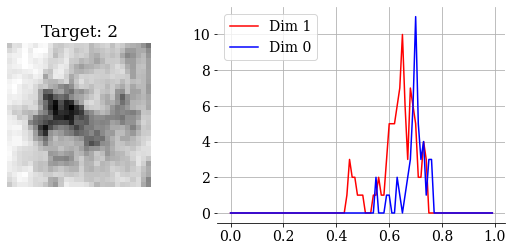

In [7]:
# The number of random samples
N = 1

# Choose random indices
sample_indices = np.random.choice(a=range(len(X)), size=N)

# Take samples
img = X[sample_indices]
tda = X_tda[sample_indices]
label = y[sample_indices]

# Visualization
fig= plt.figure(figsize=(8, 5))

ax_img = fig.add_axes([0.01, 0.3, 0.4, 0.4])
ax_img.imshow(img[0], cmap='gray'); ax_img.axis('off'); ax_img.set_title(f"Target: {label[0]}")

ax_tda = fig.add_axes([0.45, 0.2, 0.5, 0.6])
filts = np.arange(len(tda[0])) / len(tda[0])
ax_tda.plot(filts, tda[0, :, 0], 'r-', label="Dim 1")
ax_tda.plot(filts, tda[0, :, 1], 'b-', label="Dim 0")
ax_tda.grid(); ax_tda.legend();
ax_tda.spines['top'].set_visible(False)
ax_tda.spines['left'].set_visible(False)
ax_tda.spines['right'].set_visible(False)

plt.show(fig)

## 4. Modeling
- Before moving to modeling part, let divide our dataset into a training and a validation dataset.

In [8]:
y_ = y.copy()

In [9]:
from sklearn.model_selection import train_test_split
train_indices, valid_indices = train_test_split(np.arange(len(X)), stratify=y_, test_size=0.2, random_state=seed)

# One-hot encoding
n_classes = 7
y = tf.keras.utils.to_categorical(y_, n_classes) 

X_img_train, X_tda_train, y_train = X[train_indices], X_tda[train_indices], y[train_indices]
X_img_valid, X_tda_valid, y_valid = X[valid_indices], X_tda[valid_indices], y[valid_indices]

### 2D CNN
- We also provide predefined !D- and 2D-CNN.
    - The predefined 2D CNN has the architecture of O'TRAIN
    - The predefined 1D CNN has the architecture of WaveNet
- One can make a CNN by using the following codes

In [10]:
from cnntdanet.models import get_cnn_net, get_cnn_tda_net

input_shape = (28, 28, 1) 
n_classes = 7

# Build a single 2D-CNN network
cnn = get_cnn_net(input_shape=input_shape, n_classes=n_classes)
# Define a loss function, an optimization method, and evaluate metrics
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
# Train the model
history = cnn.fit(
    X_img_train, y_train,
    validation_split=0.2,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
    epochs=20
)

Epoch 1/20
201/201 [==============================] - 8s 13ms/step - loss: 1.1799 - acc: 0.6634 - val_loss: 1.1453 - val_acc: 0.6862
Epoch 2/20
201/201 [==============================] - 2s 9ms/step - loss: 1.0846 - acc: 0.6653 - val_loss: 0.9761 - val_acc: 0.6862
Epoch 3/20
201/201 [==============================] - 2s 9ms/step - loss: 1.0209 - acc: 0.6655 - val_loss: 0.9148 - val_acc: 0.6968
Epoch 4/20
201/201 [==============================] - 2s 9ms/step - loss: 0.9663 - acc: 0.6764 - val_loss: 1.0768 - val_acc: 0.6744
Epoch 5/20
201/201 [==============================] - 2s 8ms/step - loss: 0.9361 - acc: 0.6833 - val_loss: 0.9095 - val_acc: 0.7012
Epoch 6/20
201/201 [==============================] - 2s 10ms/step - loss: 0.9096 - acc: 0.6859 - val_loss: 0.8303 - val_acc: 0.7218
Epoch 7/20
201/201 [==============================] - 2s 10ms/step - loss: 0.8838 - acc: 0.6964 - val_loss: 0.8324 - val_acc: 0.7118
Epoch 8/20
201/201 [==============================] - 2s 10ms/step - loss

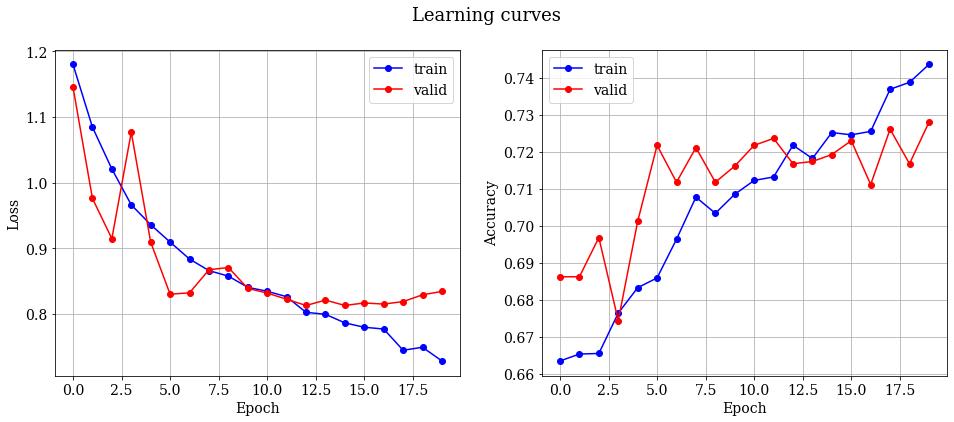

In [11]:
from cnntdanet.utils.plotting import plot_learning_curve

plot_learning_curve(history.history, dir_save=None)

- Let evaluate the 2D-CNN

In [12]:
from sklearn.metrics import accuracy_score
y_true = np.argmax(y_valid, axis=1) # From one-hot encoding to label
y_pred = cnn.predict(X_img_valid)  # Make predictions
y_pred = np.argmax(y_pred, axis=1)  # Take the maximum probability for each prediction

print(f"Accuracy: {100 * accuracy_score(y_true, y_pred):.2f}")

Accuracy: 71.44


### CNN-BC Net
- CNN-BC Net can be defined and trained as follows

Epoch 1/20
201/201 [==============================] - 6s 21ms/step - loss: 1.1401 - acc: 0.6631 - val_loss: 1.0453 - val_acc: 0.6806
Epoch 2/20
201/201 [==============================] - 4s 20ms/step - loss: 0.9948 - acc: 0.6706 - val_loss: 0.9304 - val_acc: 0.6875
Epoch 3/20
201/201 [==============================] - 4s 22ms/step - loss: 0.9357 - acc: 0.6819 - val_loss: 0.8863 - val_acc: 0.7049
Epoch 4/20
201/201 [==============================] - 4s 21ms/step - loss: 0.9066 - acc: 0.6920 - val_loss: 0.9890 - val_acc: 0.7018
Epoch 5/20
201/201 [==============================] - 4s 22ms/step - loss: 0.9056 - acc: 0.6903 - val_loss: 0.8444 - val_acc: 0.7093
Epoch 6/20
201/201 [==============================] - 4s 22ms/step - loss: 0.8815 - acc: 0.6962 - val_loss: 0.9097 - val_acc: 0.7118
Epoch 7/20
201/201 [==============================] - 4s 18ms/step - loss: 0.8770 - acc: 0.6934 - val_loss: 0.8204 - val_acc: 0.7193
Epoch 8/20
201/201 [==============================] - 4s 18ms/step - 

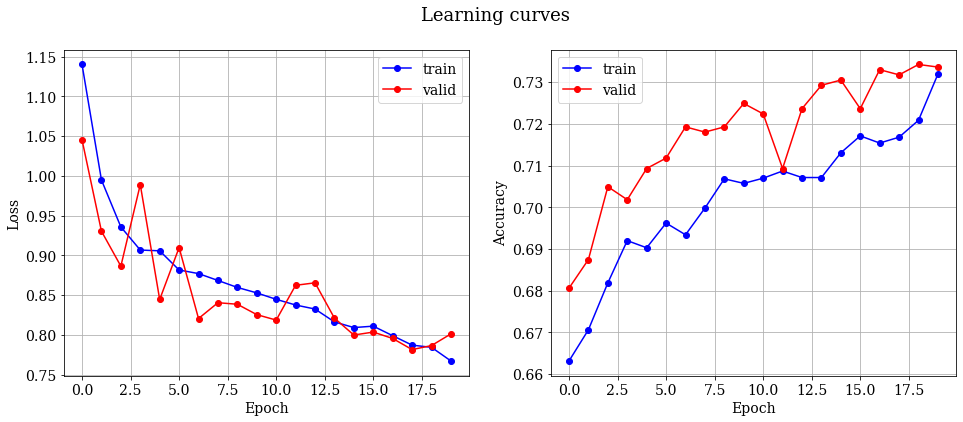

In [13]:
method = 'betti-curve'
input_shape = {'img': (28, 28, 1), 'tda': (n_bins, 2)}
n_classes = 7

# Build a single 2D-CNN network
cnn_bc = get_cnn_tda_net(method=method, input_shape=input_shape, n_classes=n_classes)
# Define a loss function, an optimization method, and evaluate metrics
cnn_bc.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
# Train the model
history = cnn_bc.fit(
    [X_img_train, X_tda_train], y_train,
    validation_split=0.2,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
    epochs=20
)

plot_learning_curve(history.history, dir_save=None)

In [14]:
y_true = np.argmax(y_valid, axis=1) # From one-hot encoding to label
y_pred = cnn_bc.predict([X_img_valid, X_tda_valid])  # Make predictions
y_pred = np.argmax(y_pred, axis=1)  # Take the maximum probability for each prediction

print(f"Accuracy: {100 * accuracy_score(y_true, y_pred):.2f}")

Accuracy: 72.54


## 5. Grad-CAM Analysis
- We also provide [Grad-CAM](https://arxiv.org/abs/1610.02391) analysis for a CNN and a CNN-TDA Net.


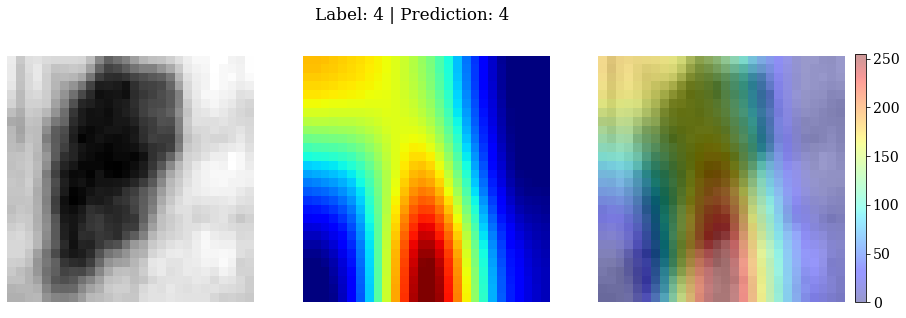

In [15]:
from cnntdanet.gradcam import GradCAMOnCNN

idx = 9
img = X_img_valid[idx:idx+1]
label = np.argmax(y_valid, axis=1)[idx]

gradcam_cnn = GradCAMOnCNN(cnn, layer_name='conv2d_4')
gradcam_cnn.to_heatmap(img, true_label=label)
gradcam_cnn.visualize()

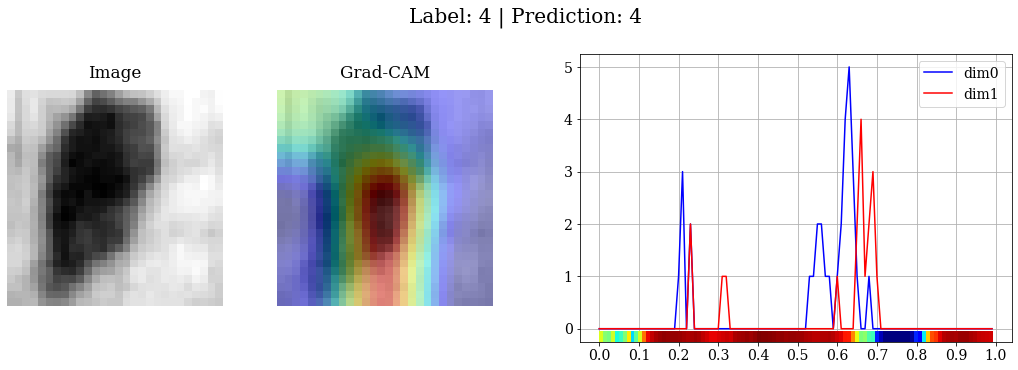

In [16]:
from cnntdanet.gradcam import GradCAMOnCNNTDANet

idx = 9
img = X_img_valid[idx:idx+1]
tda = X_tda_valid[idx:idx+1]
label = np.argmax(y_valid, axis=1)[idx]

gradcam_cnn_tda = GradCAMOnCNNTDANet(cnn_bc, local_layer_name='conv2d_9', global_layer_name='conv1d_8')
gradcam_cnn_tda.to_heatmap([img, tda], true_label=label)
gradcam_cnn_tda.visualize()